# Scaled Dot Product Atention

In [12]:
import math 
import torch 
from torch import nn 
from d2l import torch as d2l

**Masked Softmax Operation**

- In many applications, especially when dealing with sequences with different lengths, we often pad or add other dummy tokens which carry no significant values and we will like them to be given no attention. 

- Immagine that given an n-lengthed values, only l <= n are real and from l+1 -> n are dummy values. We will want the softmax to mask them out in order for them to be given Zero attention. We could multiply by zero. Since we are using exponentiation in practice, we assign to them very large negative weights for them to vanish after exp()

- **THis is called Masked Softmax Operation**

In [13]:
def masked_softmax(X, valid_lens):  # @save
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)

        # Will contain zero for all values outside of the valid length or range
        mask = (
            torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :]
            < valid_len[:, None]
        )

        X[~mask] = value
        return X

    if valid_lens is None:
        # In case all values are relevant, no mask
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)

        # For stability purpose, replace masked elements with large negative
        # values so that the exponent can give 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [14]:
X = torch.rand(2, 2, 4)
# The valid lengths for each of the 2 2x4 arrays
valid_lens = torch.tensor([2, 3])

print("\n", masked_softmax(X, torch.tensor([2, 3])))


 tensor([[[0.5286, 0.4714, 0.0000, 0.0000],
         [0.4684, 0.5316, 0.0000, 0.0000]],

        [[0.3114, 0.4262, 0.2624, 0.0000],
         [0.4601, 0.2690, 0.2709, 0.0000]]])


**Batch Matrix Multiplication (BMM)**

- Assume that `Q = [Q1, Q2, ..., Qn]` (n x a x b) and `K= [K1, K2,..., Kn]` (n x b x c)

- `BMM(Q, K) = [Q1K1, Q2.K2, ..., Qn.Kn]` (n x a x c)


In [15]:
Q = torch.ones((2,3,4))
K = torch.ones((2,4,6))
d2l.check_shape(torch.bmm(Q,K), (2,3,6))

1. **Scaled Dot Product Attention**

`softmax(QK.T / d^0.5).V` 

In [16]:
class DotProductAttention(nn.Module):  # @save
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [25]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

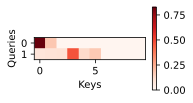

In [26]:
# To show that the s3cond and the 6th components are ignored as pe the valid_lens
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries"
)

2. **Additive Attention**
`a(q, k) = w_v.T(tanh(W_q.q + W_k.k)`

AN interpretation is that of a query and key fed into an MLP with single layer and using the tanh activation function with no bias term


In [28]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)

        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)

        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)

        return torch.bmm(self.dropout(self.attention_weights), values)

In [33]:
queries = torch.normal(0, 1, (2, 1, 20))
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

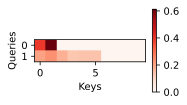

In [34]:
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries"
)

**Summary**

- We were presented with 2 attention scoring functions: Additive and Dot product as they are effective tools for aggregating sequences accross variable lengths. 

- **Dot product attention** Is the most popular and the one used in Transformer archs.